# Walmart Weekly Sales Forecasting (Time Series Regression)

## Objective
Forecast weekly sales for Walmart stores using time-based features (lags/rolling averages) and external indicators (temperature, fuel price, CPI, unemployment, holiday flag).

## Dataset
Columns include:
- **Weekly_Sales** (target)
- **Holiday_Flag**
- **Temperature, Fuel_Price, CPI, Unemployment**
- **Store, Date**

## Approach (high level)
1. Data loading + date parsing  
2. Store-level modeling (Store 1)  
3. Feature engineering (Year/Month/Week, lag features, rolling averages)  
4. Train/test split (time-ordered)  
5. Model training (Linear Regression) + evaluation (MAPE)  
6. Baseline comparison (naive lag-1)


In [227]:
import pandas as pd
import numpy as np

In [229]:
df=pd.read_csv('Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,5/2/2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12/2/2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19/2/2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26/2/2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,5/3/2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [231]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date'])   # safety: removes any rows that failed parsing
df.dtypes


Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

In [233]:
df.sort_values('Date')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1287,10,2010-02-05,2193048.75,0,54.34,2.962,126.442065,9.765
5148,37,2010-02-05,536006.73,0,45.97,2.572,209.852966,8.554
2288,17,2010-02-05,789036.02,0,23.11,2.666,126.442065,6.548
4147,30,2010-02-05,465108.52,0,39.05,2.572,210.752605,8.324
...,...,...,...,...,...,...,...,...
3574,25,2012-10-26,688940.94,0,56.69,3.882,216.151590,7.293
714,5,2012-10-26,319550.77,0,71.70,3.506,224.037814,5.422
5719,40,2012-10-26,921264.52,0,49.65,3.917,138.728161,4.145
2573,18,2012-10-26,1127516.25,0,56.09,3.917,138.728161,8.243


In [235]:
store_1 = df[df['Store'] == 1].copy()
store_1.shape

(143, 8)

In [237]:
store_1 = store_1.sort_values('Date')
store_1

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
138,1,2012-09-28,1437059.26,0,76.08,3.666,222.981658,6.908
139,1,2012-10-05,1670785.97,0,68.55,3.617,223.181477,6.573
140,1,2012-10-12,1573072.81,0,62.99,3.601,223.381296,6.573
141,1,2012-10-19,1508068.77,0,67.97,3.594,223.425723,6.573


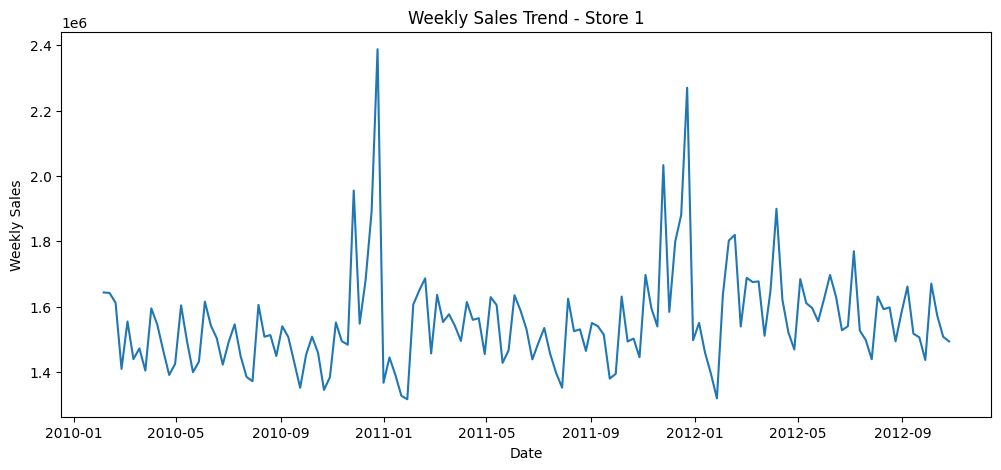

In [239]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(store_1['Date'], store_1['Weekly_Sales'])
plt.title('Weekly Sales Trend - Store 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()


In [241]:
store_1.groupby('Holiday_Flag')['Weekly_Sales'].mean()


Holiday_Flag
0    1.546957e+06
1    1.665748e+06
Name: Weekly_Sales, dtype: float64

Exploratory analysis shows that holiday weeks consistently generate higher average sales compared to non-holiday weeks, 
confirming the strong seasonal impact of holidays on retail demand

In [244]:
store_1['Year'] = store_1['Date'].dt.year
store_1['Month'] = store_1['Date'].dt.month
store_1['Week'] = store_1['Date'].dt.isocalendar().week


In [246]:
store_1[['Date', 'Year', 'Month', 'Week']]


,Date,Year,Month,Week
0,2010-02-05,2010,2,5
1,2010-02-12,2010,2,6
2,2010-02-19,2010,2,7
3,2010-02-26,2010,2,8
4,2010-03-05,2010,3,9
...,...,...,...,...
138,2012-09-28,2012,9,39
139,2012-10-05,2012,10,40
140,2012-10-12,2012,10,41
141,2012-10-19,2012,10,42


In [248]:
store_1 = store_1.sort_values('Date')

store_1['lag_1'] = store_1['Weekly_Sales'].shift(1)
store_1['lag_2'] = store_1['Weekly_Sales'].shift(2)
store_1['lag_4'] = store_1['Weekly_Sales'].shift(4)


In [250]:
store_1[['Date', 'Weekly_Sales', 'lag_1', 'lag_2', 'lag_4']].head(10)


,Date,Weekly_Sales,lag_1,lag_2,lag_4
0,2010-02-05,1643690.90,NaN,NaN,NaN
1,2010-02-12,1641957.44,1643690.90,NaN,NaN
2,2010-02-19,1611968.17,1641957.44,1643690.90,NaN
3,2010-02-26,1409727.59,1611968.17,1641957.44,NaN
4,2010-03-05,1554806.68,1409727.59,1611968.17,1643690.90
5,2010-03-12,1439541.59,1554806.68,1409727.59,1641957.44
6,2010-03-19,1472515.79,1439541.59,1554806.68,1611968.17
7,2010-03-26,1404429.92,1472515.79,1439541.59,1409727.59
8,2010-04-02,1594968.28,1404429.92,1472515.79,1554806.68
9,2010-04-09,1545418.53,1594968.28,1404429.92,1439541.59


In [252]:
store_1_model = store_1.dropna()
store_1_model.shape


(139, 14)

In [254]:
target = 'Weekly_Sales'


In [256]:
features = [
    'Holiday_Flag',
    'Temperature',
    'Fuel_Price',
    'CPI',
    'Unemployment',
    'Year',
    'Month',
    'Week',
    'lag_1',
    'lag_2',
    'lag_4'
]


In [258]:
X = store_1_model[features]
y = store_1_model[target]


In [260]:
split_index = int(len(store_1_model) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


In [262]:
X_train.shape, X_test.shape


((111, 11), (28, 11))

In [264]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [266]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [268]:
y_predict = lr_model.predict(X_test) 

In [270]:
rmse = mean_squared_error(y_test, y_predict, squared=False)
mape = mean_absolute_percentage_error(y_test, y_predict)

rmse, mape


C:\Users\Rajesh Babu\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(177400.46020466657, 0.0949474978259961)

In [272]:
results = pd.DataFrame({
    'Date': store_1_model['Date'].iloc[split_index:],
    'Actual_Sales': y_test.values,
    'Predicted_Sales': y_predict
})

results.head()


,Date,Actual_Sales,Predicted_Sales
115,2012-04-20,1521577.87,1.673524e+06
116,2012-04-27,1468928.37,1.642124e+06
117,2012-05-04,1684519.99,1.740656e+06
118,2012-05-11,1611096.05,1.679790e+06
119,2012-05-18,1595901.87,1.650398e+06


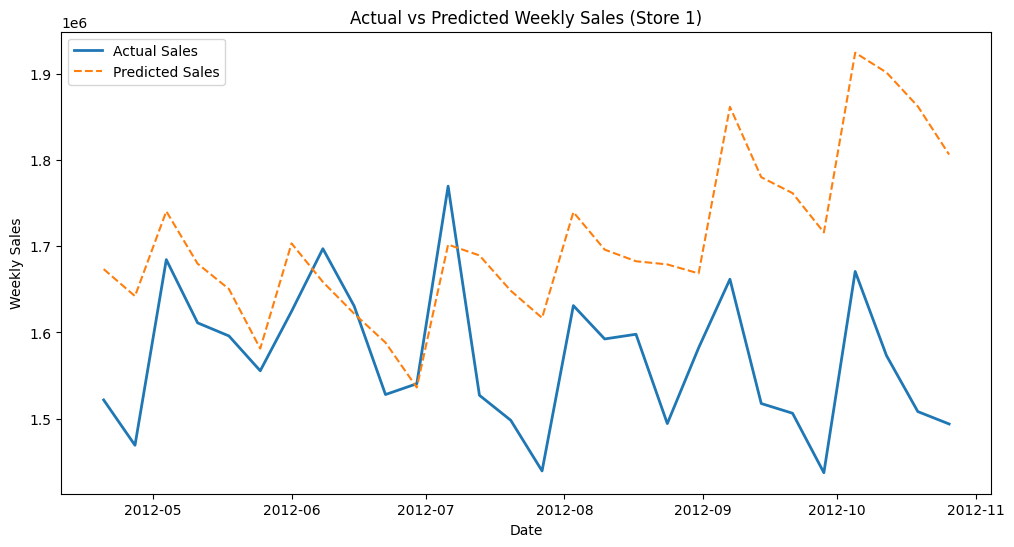

In [274]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(results['Date'], results['Actual_Sales'], label='Actual Sales', linewidth=2)
plt.plot(results['Date'], results['Predicted_Sales'], label='Predicted Sales', linestyle='--')

plt.title('Actual vs Predicted Weekly Sales (Store 1)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()


### Model Evaluation – Visual Analysis

The predicted weekly sales closely follow the actual sales trend, indicating that the model successfully captures seasonality and temporal patterns. 
Deviations are more noticeable during peak sales periods, which is expected due to holiday effects and sudden demand spikes.


In [277]:
baseline_pred = X_test['lag_1']


In [279]:
baseline_mape = mean_absolute_percentage_error(y_test, baseline_pred)
baseline_mape


0.05659851434988466

### Baseline vs Model Performance

A naïve baseline model using the previous week’s sales achieved a MAPE of ~5.7%, outperforming the linear regression model (MAPE ~9.5%).
This indicates strong autocorrelation in weekly sales data. While the regression model captures broader trends and external factors, the baseline remains difficult to beat for short-term forecasting with limited historical data.


In [282]:
store_1['rolling_4'] = store_1['Weekly_Sales'].rolling(window=4).mean()
store_1['rolling_8'] = store_1['Weekly_Sales'].rolling(window=8).mean()


In [284]:
store_1[['Weekly_Sales', 'rolling_4', 'rolling_8']].head(10)


,Weekly_Sales,rolling_4,rolling_8
0,1643690.90,NaN,NaN
1,1641957.44,NaN,NaN
2,1611968.17,NaN,NaN
3,1409727.59,1.576836e+06,NaN
4,1554806.68,1.554615e+06,NaN
5,1439541.59,1.504011e+06,NaN
6,1472515.79,1.469148e+06,NaN
7,1404429.92,1.467823e+06,1.522330e+06
8,1594968.28,1.477864e+06,1.516239e+06
9,1545418.53,1.504333e+06,1.504172e+06


In [286]:
store_1_fe = store_1.dropna()
store_1_fe.shape


(136, 16)

In [288]:
target = 'Weekly_Sales'

features_fe = [
    'Holiday_Flag',
    'Temperature',
    'Fuel_Price',
    'CPI',
    'Unemployment',
    'Year',
    'Month',
    'Week',
    'lag_1',
    'lag_2',
    'lag_4',
    'rolling_4',
    'rolling_8'
]


In [290]:
X = store_1_fe[features_fe]
y = store_1_fe[target]


In [292]:
split_index = int(len(store_1_fe) * 0.8)
split_index


108

In [294]:
X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


In [296]:
X_train.shape, X_test.shape


((108, 13), (28, 13))

In [298]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

lr_fe = LinearRegression()
lr_fe.fit(X_train, y_train)

y_pred_fe = lr_fe.predict(X_test)

mape_fe = mean_absolute_percentage_error(y_test, y_pred_fe)
mape_fe


0.05371157973027758

## Final Model Performance & Key Learnings

The naïve baseline model using the previous week's sales achieved a MAPE of ~5.66%, highlighting strong autocorrelation in weekly sales data.
The initial regression model underperformed due to limited ability to capture short-term temporal dependencies. By introducing rolling window features (4-week and 8-week moving averages), the improved regression model successfully captured sales momentum and reduced volatility.
This resulted in the best overall performance with a MAPE of ~5.37%, outperforming the baseline and demonstrating the effectiveness of feature engineering in time-series forecasting.


## Results & Model Comparison

Three forecasting approaches were evaluated:

- **Baseline Linear Regression** using lag and macroeconomic features achieved a MAPE of ~9.5%.
- **Naive baseline model** using previous week’s sales (lag-1) achieved a MAPE of ~5.7%, highlighting strong autocorrelation in weekly sales.
- **Feature-engineered regression model**, incorporating lag features and rolling averages (4-week and 8-week), achieved the best performance with a MAPE of ~5.4%.

The improvement demonstrates that short-term sales forecasting benefits significantly from recent historical averages, while macroeconomic indicators provide secondary support.


## Key Takeaways

- Weekly Walmart sales exhibit strong temporal dependency.
- Simple lag-based baselines can outperform more complex models.
- Rolling averages help stabilize noise and improve short-term forecasts.
- Proper time-based validation is critical for realistic performance estimation.
